In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2 as cv
import math
from PIL import Image, ImageDraw, ImageFont, ImageColor

## Import image

In [2]:
img_path = "/home/thierry/code/zuzannaszu/chess_hackers/Raw_Data/new_chess_data/boards/"
img_set = []
img_num = []
start = 41
for i in range(start,start + 10):
    img = cv.imread(img_path + f"board{i}.jpeg", 0)
    img_set.append(img)
    img_num.append(i)
img_set = np.array(img_set)
img_set.shape

(10, 1280, 1280)

In [3]:
def display_multiple_img(array):
    fig, axs = plt.subplots(5,2,figsize=(10,20))
    for i, img in enumerate (array, 1):
        plt.subplot(5,2,i)
        plt.imshow(img)
        plt.title(f"board{start - 1 + i}")
        
def display_compare_img(array1, array2):
    fig, axs = plt.subplots(5,4,figsize=(20,20))
    for i, img in enumerate (zip(array1, array2), 1):
        plt.subplot(5,4, 2 * i - 1)
        plt.imshow(img[0])
        plt.title(f"board{start - 1 + i}")
        plt.subplot(5,4, 2 * i)
        plt.imshow(img[1])
        plt.title(f"board{start - 1 + i}")

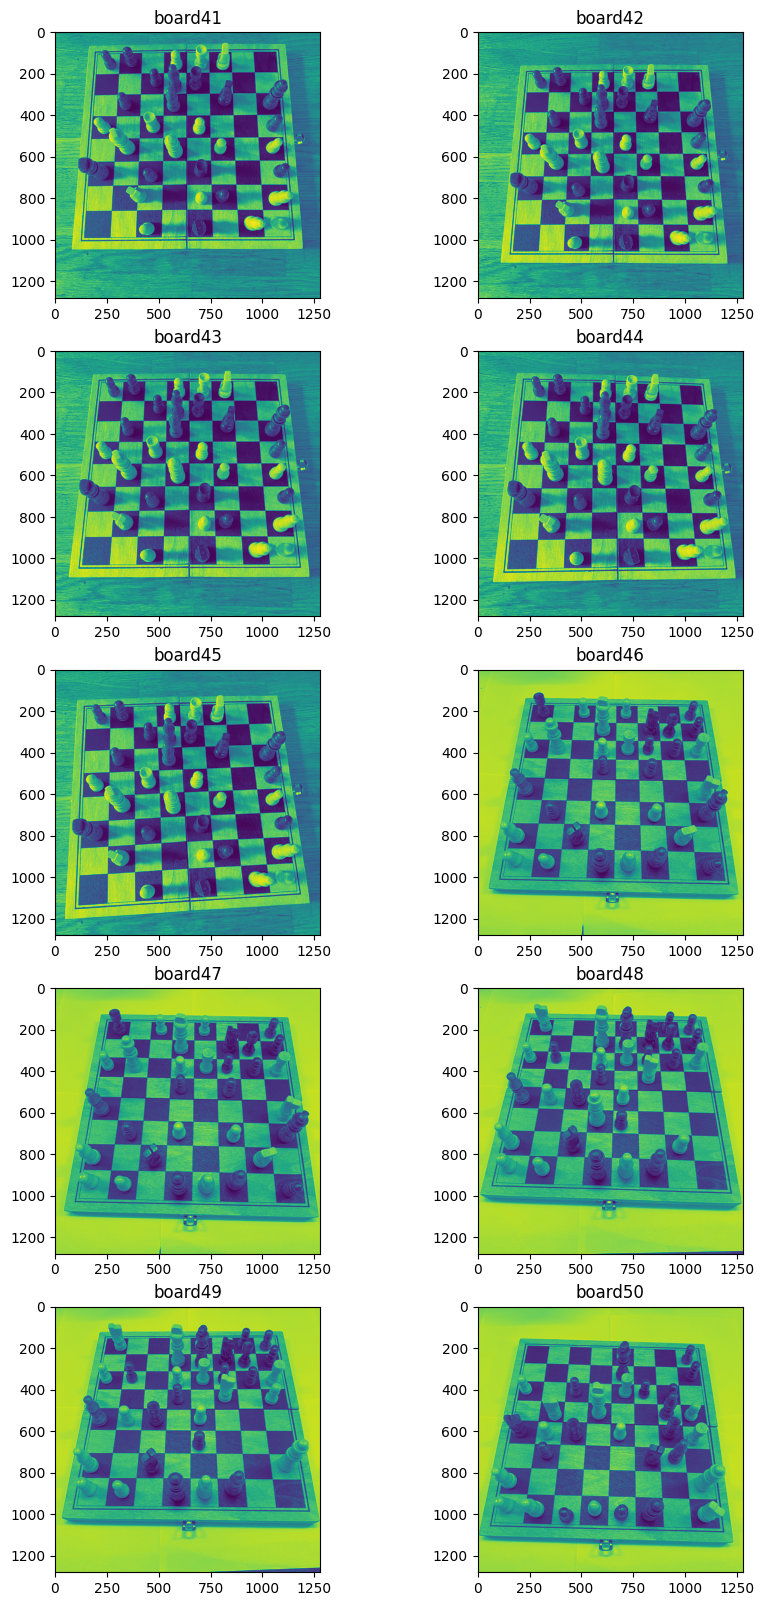

In [4]:
display_multiple_img(img_set)

## Image processing

### Background removal

In [26]:
def bgremove1(myimage):
 
    # Blur to image to reduce noise
    myimage = cv.cvtColor(myimage, cv.COLOR_GRAY2RGB)
    #myimage = cv.GaussianBlur(myimage,(7,7), 0)
 
    # We bin the pixels. Result will be a value 1..5
    bins=np.array([0,51,102,153,204,255])
    myimage[:,:,:] = np.digitize(myimage[:,:,:],bins,right=True)*51
 
    # Create single channel greyscale for thresholding
    myimage_grey = cv.cvtColor(myimage, cv.COLOR_BGR2GRAY)
 
    # Perform Otsu thresholding and extract the background.
    # We use Binary Threshold as we want to create an all white background
    ret,background = cv.threshold(myimage_grey,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
 
    # Convert black and white back into 3 channel greyscale
    background = cv.cvtColor(background, cv.COLOR_GRAY2BGR)
 
    # Perform Otsu thresholding and extract the foreground.
    # We use TOZERO_INV as we want to keep some details of the foregorund
    ret,foreground = cv.threshold(myimage_grey,0,255,cv.THRESH_TOZERO_INV+cv.THRESH_OTSU)  #Currently foreground is only a mask
    foreground = cv.bitwise_and(myimage,myimage, mask=foreground)  # Update foreground with bitwise_and to extract real foreground
 
    # Combine the background and foreground to obtain our final image
    finalimage = background+foreground
 
    return finalimage

def background_op(img, alpha = 1, beta = 0):
    alpha = alpha # Simple contrast control
    beta = beta    # Simple brightness control
    
    image = cv.GaussianBlur(img,(7,7), 0)
    new_image = np.clip(alpha*image + beta, 0, 255).astype("uint8")
    image_1 = bgremove1(new_image)
    
    return image_1

In [56]:
image = img_set[2]

image_1 = background_op(image, 1.5, -50)

fig, axs = plt.subplots(1,2,figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(image_1)

### Canny detector

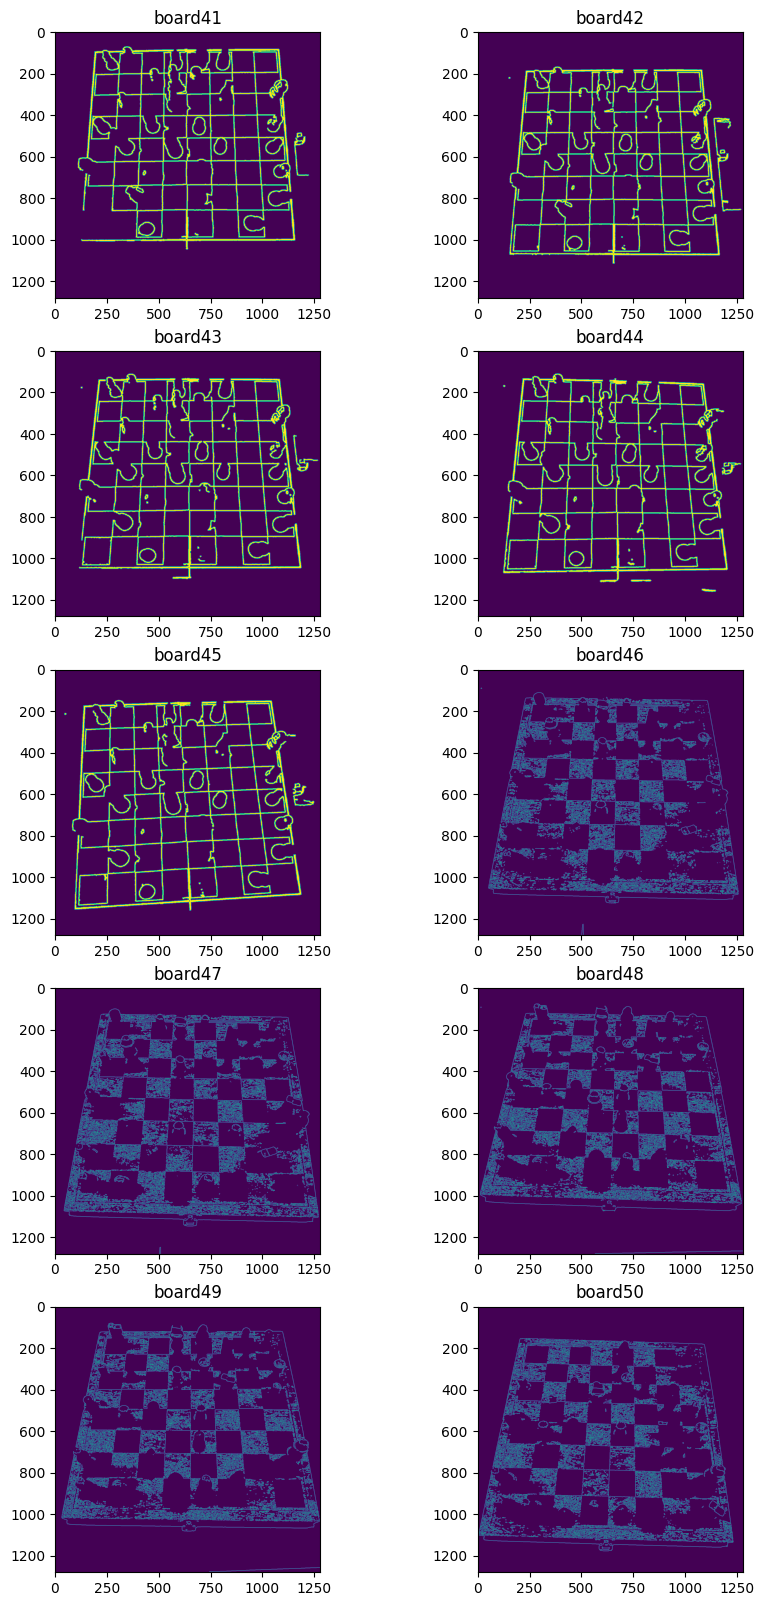

In [127]:
edges = []
for img in img_set:
    v = np.median(img)
    sigma = 0.50
    lower = int((1.0 - sigma))
    upper = int((1.0 + sigma) * 5 * v)
    if v < 150:
        img = background_op(img, 1.9, -70)
    else:
        img = cv.threshold(img,v,255,cv.THRESH_BINARY)[1]
    edge = cv.Canny(img, lower, upper) #70,250 for old
    if v < 150:
        kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(6,6))
        edge = cv.dilate(edge, kernel, iterations=1)
    edges.append(edge)
edges = np.array(edges)
display_multiple_img(edges)

### Contours

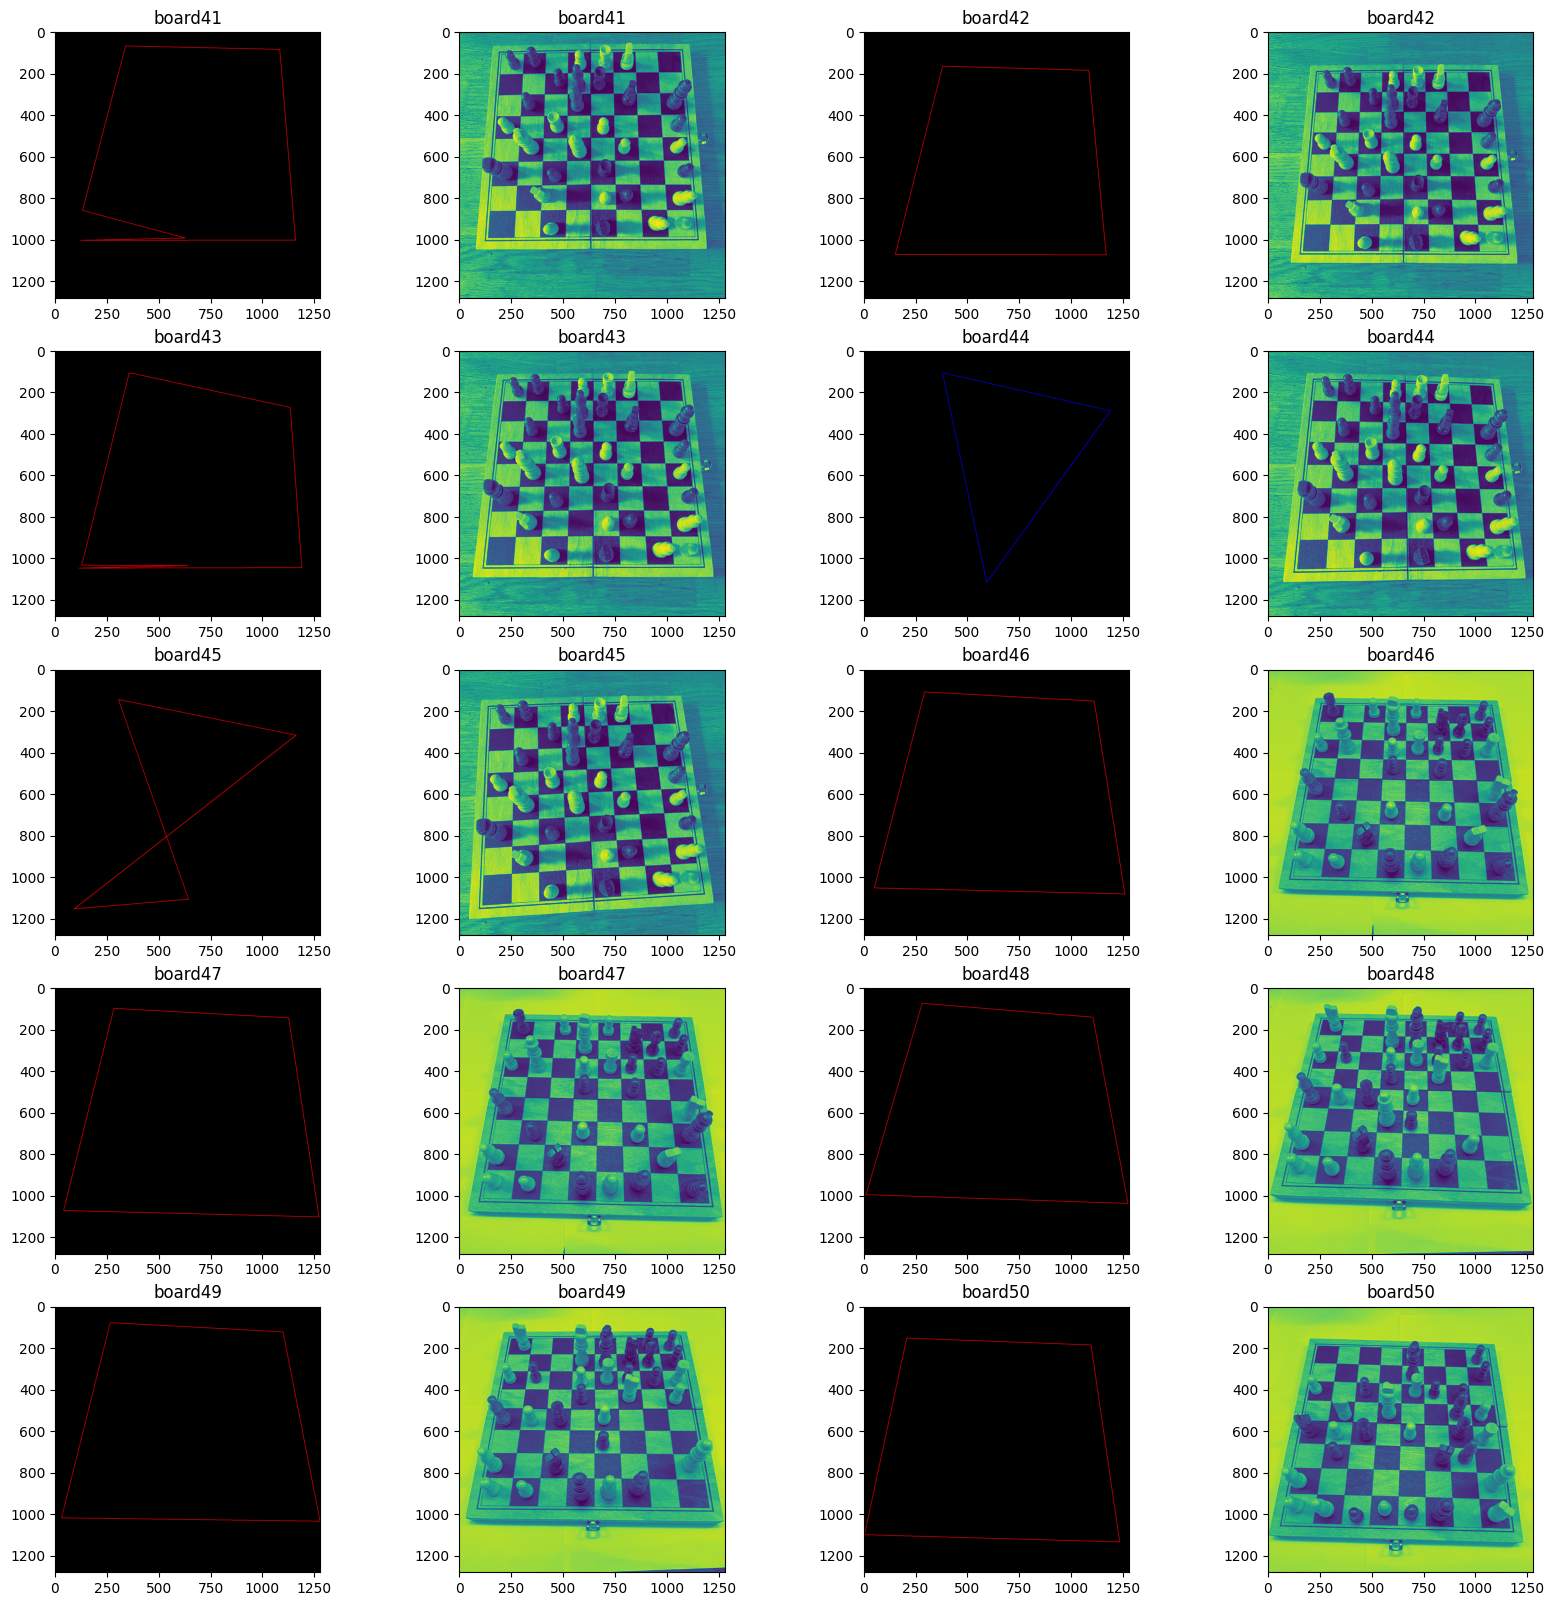

In [128]:
img_black = []
good_contour = []

for edge in edges:

    black = np.zeros((1280, 1280, 3), dtype = np.uint8)
    
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
    dilated = cv.dilate(edge, kernel, iterations=2)
    
    contours, hierarchy = cv.findContours(dilated, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    for idx, contour in enumerate (contours):
        # Approximate the contour shape to a polygon
        peri = cv.arcLength(contour, True)
        if peri > 3000:
            polygon = cv.approxPolyDP(contour, epsilon=0.05*cv.arcLength(contour, True), closed=False)
            sides = len(polygon)
            if sides < 4:
                pass
                #cv.drawContours(black, [polygon], 0, (0, 255, 0), 2)
            elif sides == 4:
                cv.drawContours(black, [polygon], 0, (0, 0, 255), 2)
            else:
                real_one = idx
                cv.drawContours(black, [polygon], 0, (255, 0, 0), 2)
                good_contour.append(polygon)
            
    img_black.append(black)
    

img_black = np.array(img_black)
display_compare_img(img_black, img_set)

### Corner making

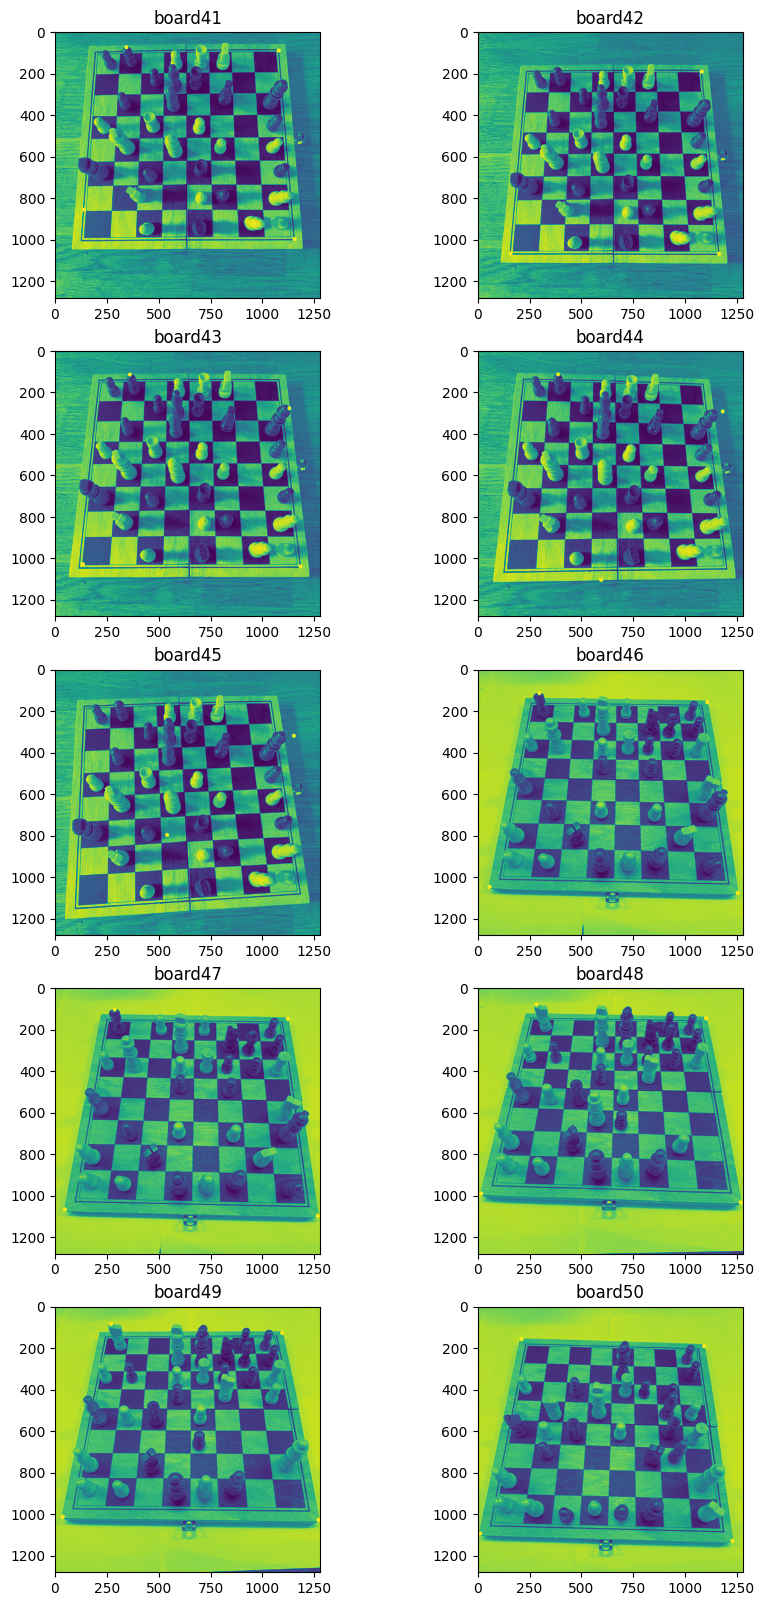

In [129]:
corner_list = []
corner_img = []
for img_b, img in zip(img_black, img_set):
    new_img = img.copy()
    img_b = cv.cvtColor(img_b, cv.COLOR_BGR2GRAY)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
    img_b = cv.dilate(img_b, kernel, iterations=3)
    corners = cv.goodFeaturesToTrack(img_b, 4, 0.4, 700)
    if corners is not None:
        corners = np.int0(corners)
        point_corners = []
        for corner in corners:
            x, y = corner.ravel()
            cv.circle(new_img, (x,y), 10, 255, -1)
            point_corners.append([x,y])
        corner_list.append(point_corners)
        corner_img.append(new_img)
    else:
        corner_list.append(point_corners)
        corner_img.append(np.zeros((1280, 1280), dtype = np.uint8))
display_multiple_img(corner_img)

In [130]:
corner_ordered = []
for corners in corner_list:
    if len(corners) > 3:
        pts = np.array(corners)
        center = np.mean(pts, axis=0)
        # Sort the points in clockwise
        cyclic_pts = [
                # Top-left
                pts[np.where(np.logical_and(pts[:, 0] < center[0], pts[:, 1] < center[1]))[0][0], :].tolist(),
                # Top-right
                pts[np.where(np.logical_and(pts[:, 0] > center[0], pts[:, 1] < center[1]))[0][0], :].tolist(),
                # Bottom-Right
                pts[np.where(np.logical_and(pts[:, 0] > center[0], pts[:, 1] > center[1]))[0][0], :].tolist(),
                # Bottom-Left
                pts[np.where(np.logical_and(pts[:, 0] < center[0], pts[:, 1] > center[1]))[0][0], :].tolist()]

        corner_ordered.append(cyclic_pts)
    else: corner_ordered.append(None)

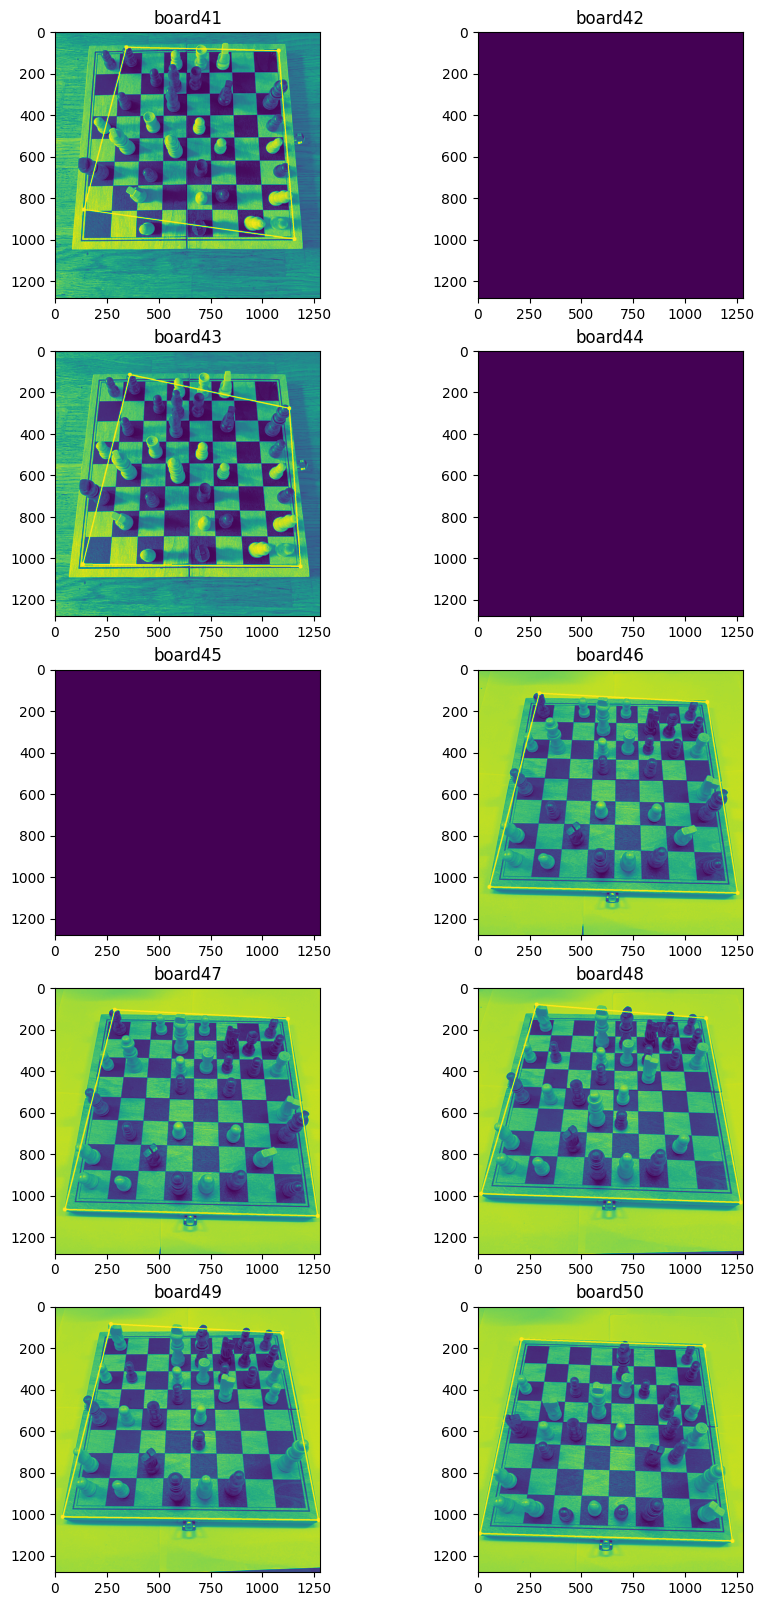

In [131]:
corner_drawn = []
for corners, img in zip(corner_ordered, corner_img):
    if corners is not None:
        i = 4
        while i > 0:
            c = i % 4
            cv.line(img, corners[c], corners[c-1], color = 255, thickness=5)
            i -=1
        corner_drawn.append(img)
    else: corner_drawn.append(np.zeros((1280, 1280), dtype = np.uint8))
display_multiple_img(corner_drawn)

### Reshaping the images

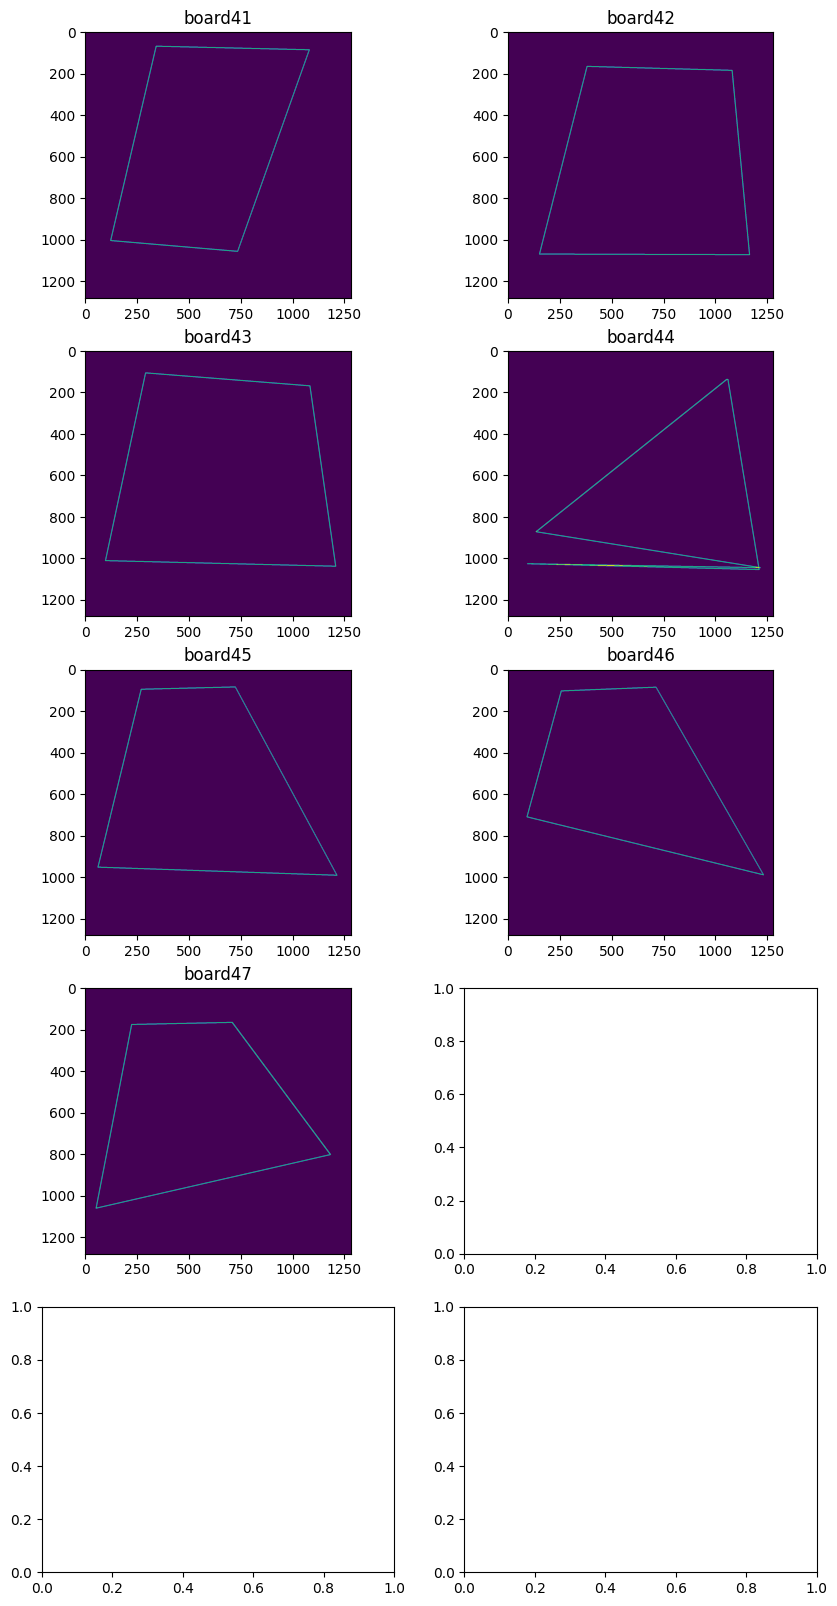

In [12]:
test = []
for cont in good_contour:
    black = np.zeros((1280, 1280), dtype = np.uint8)
    cv.drawContours(black, [cont], 0, (255, 0, 0), 2)
    test.append(black)
display_multiple_img(test)

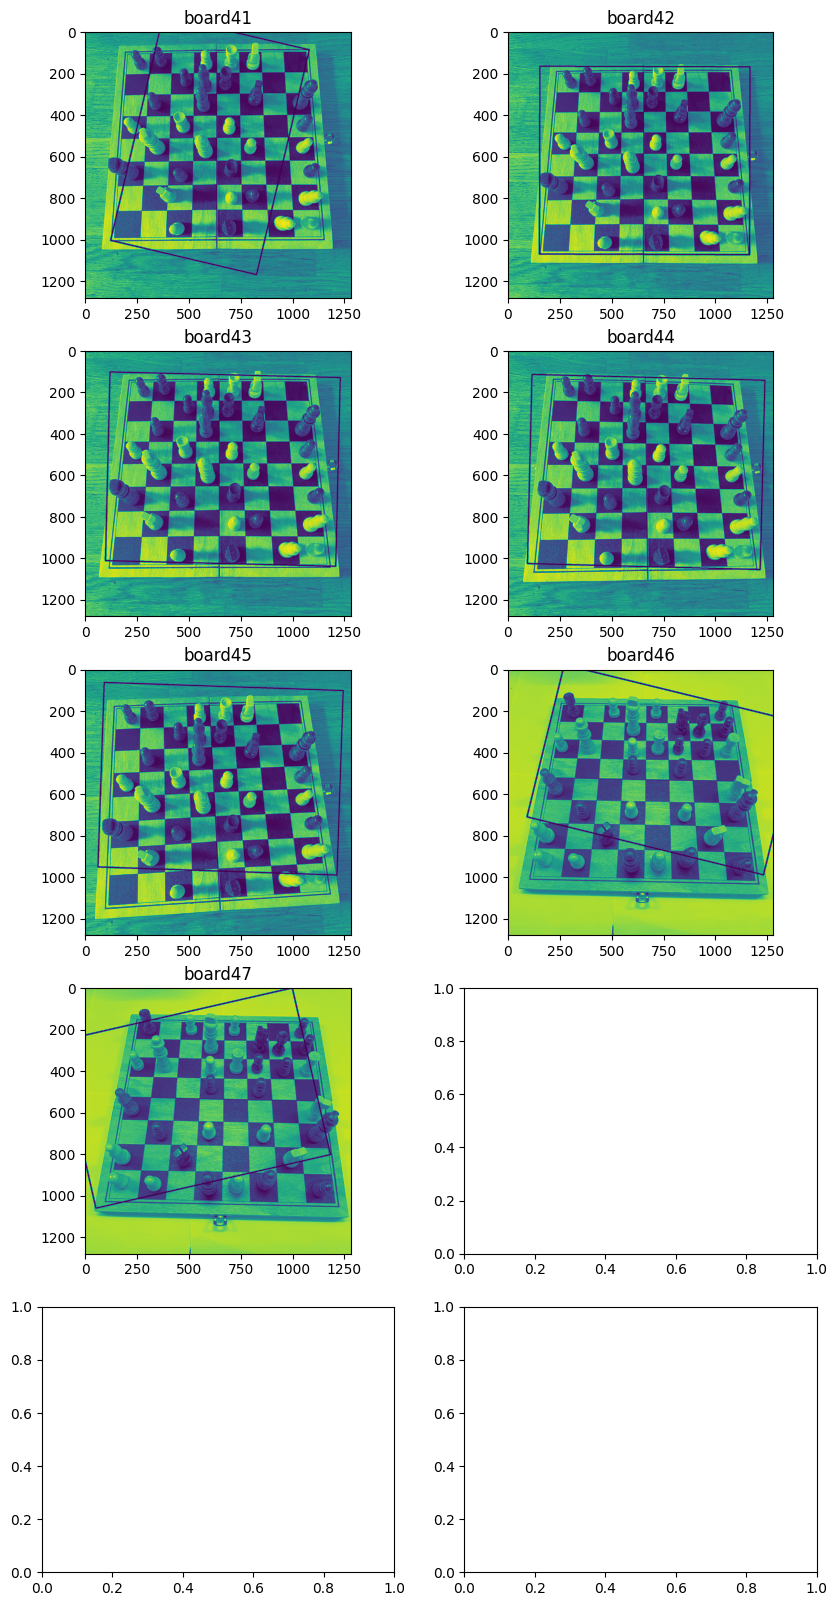

In [13]:
prep_img = []
rotated_points = []
img_dim = []

for cont, img in zip(good_contour, img_set):
    
    rotatedRect = cv.minAreaRect(cont)
    (x, y), (width, height), angle = rotatedRect
    rotatedRectPts = cv.boxPoints(rotatedRect)
    rotatedRectPts = np.int0(rotatedRectPts)
    top = rotatedRectPts[1]
    bottom = rotatedRectPts[3]

    out = img.copy()
    cv.drawContours(out, [rotatedRectPts], 0, (0, 255, 0), 5)
    prep_img.append(out)
    img_dim.append((width, height))
    rotated_points.append(rotatedRectPts)
    
display_multiple_img(prep_img)

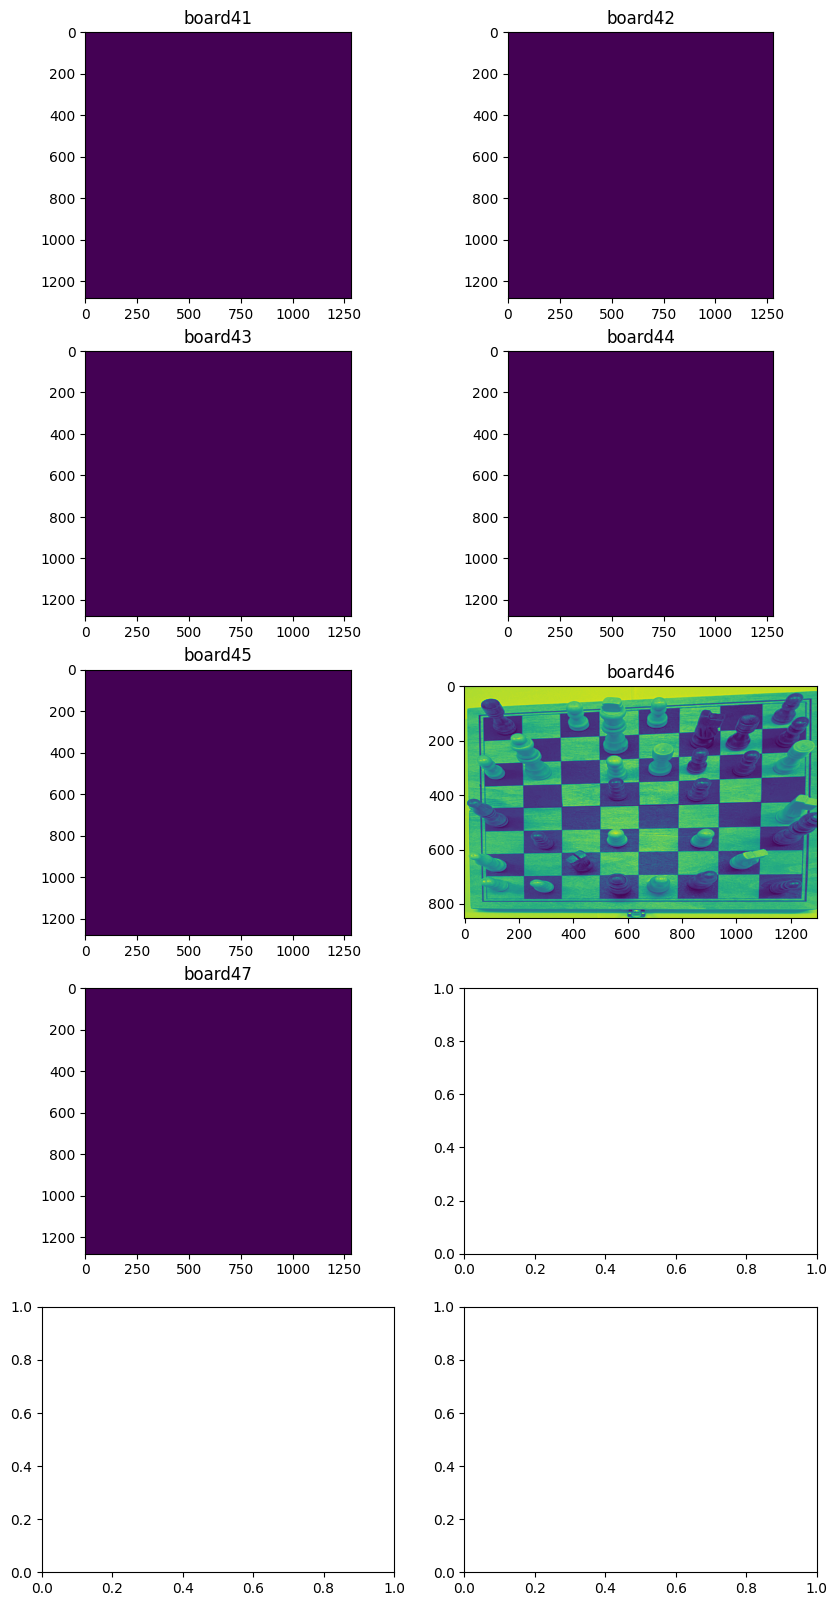

In [14]:
trans_img = []

for img, corners, dim in zip(img_set, corner_ordered, img_dim):
    if corners is not None:
    
        # Top-left, bottom-left, bottom-right, top-right, 
        dstPts = [[0, 0], [dim[0], 0], [dim[0], dim[1]], [0, dim[1]]]
        # Get the transform
        m = cv.getPerspectiveTransform(np.float32(corners), np.float32(dstPts))

        #add padding
        padding = 50
        m[0,2] += padding + 50
        m[1,2] += padding

        # Transform the image
        out = cv.warpPerspective(img, m, (int(dim[0]+ 2*padding + 25), int(dim[1]+ 2*padding)))
        trans_img.append(out)
    else: trans_img.append(np.zeros((1280, 1280), dtype = np.uint8))
display_multiple_img(trans_img)

## Coordinate system generation

### Hough lines transform

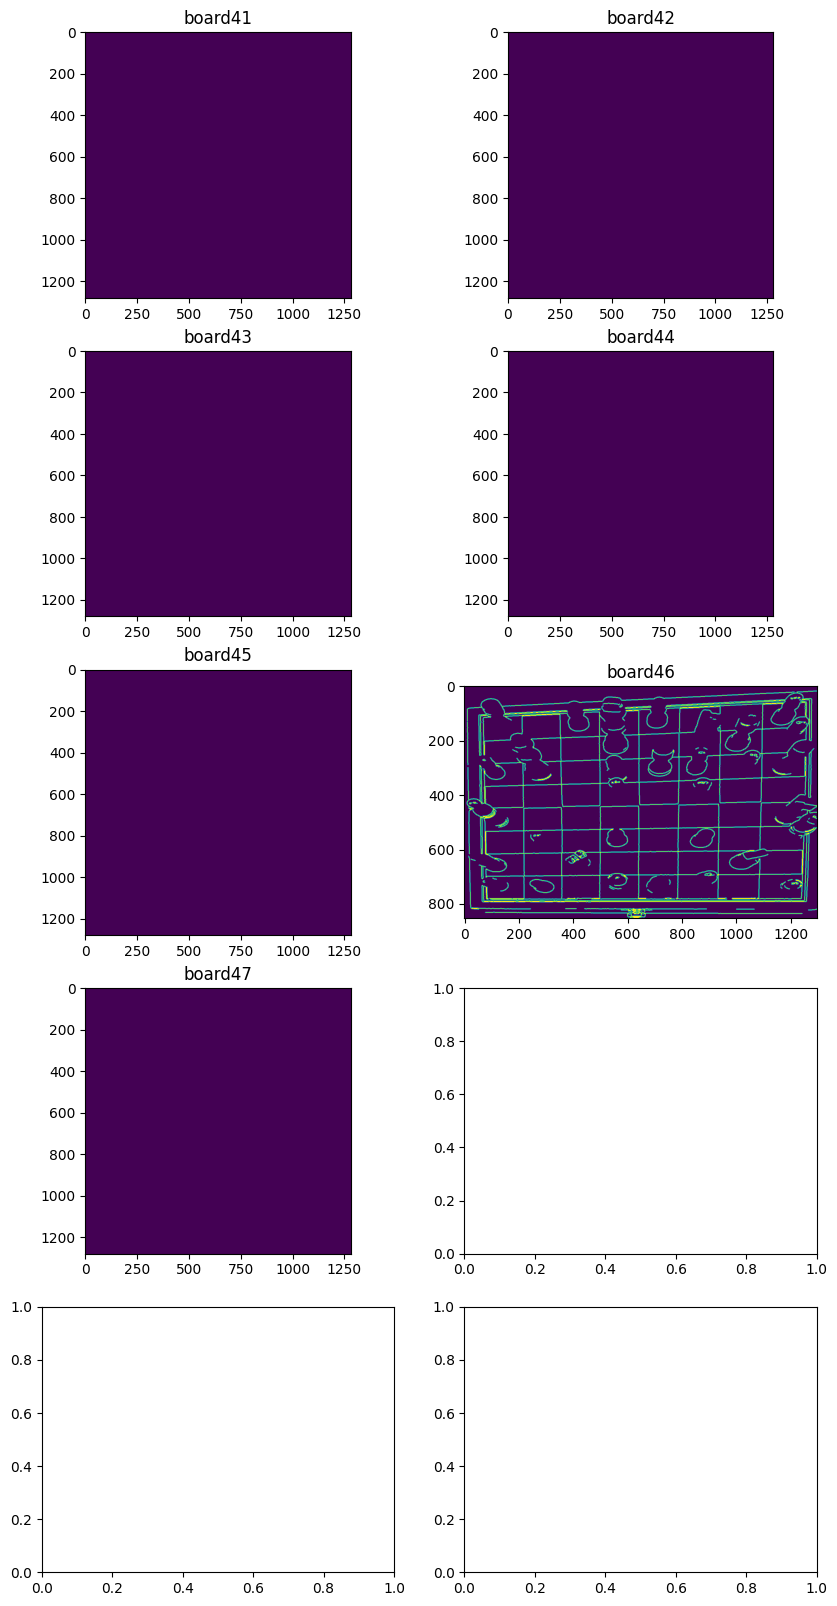

In [16]:
trans_edges = []

for img in trans_img: 
    v = np.median(img)
    sigma = 0.2
    lower = int((1.0 - sigma) * v)
    upper = int((1.0 + sigma) * v)
    #print(f"lower {lower}, upper {upper}")
    #thres = cv.threshold(img,v-10,255,cv.THRESH_BINARY)
    blur = cv.blur(img,(3,3),0) 
    edge = cv.Canny(blur, upper, lower) #70,250 for old
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
    dilated = cv.dilate(edge, kernel, iterations=1)
    trans_edges.append(dilated)
display_multiple_img(trans_edges)

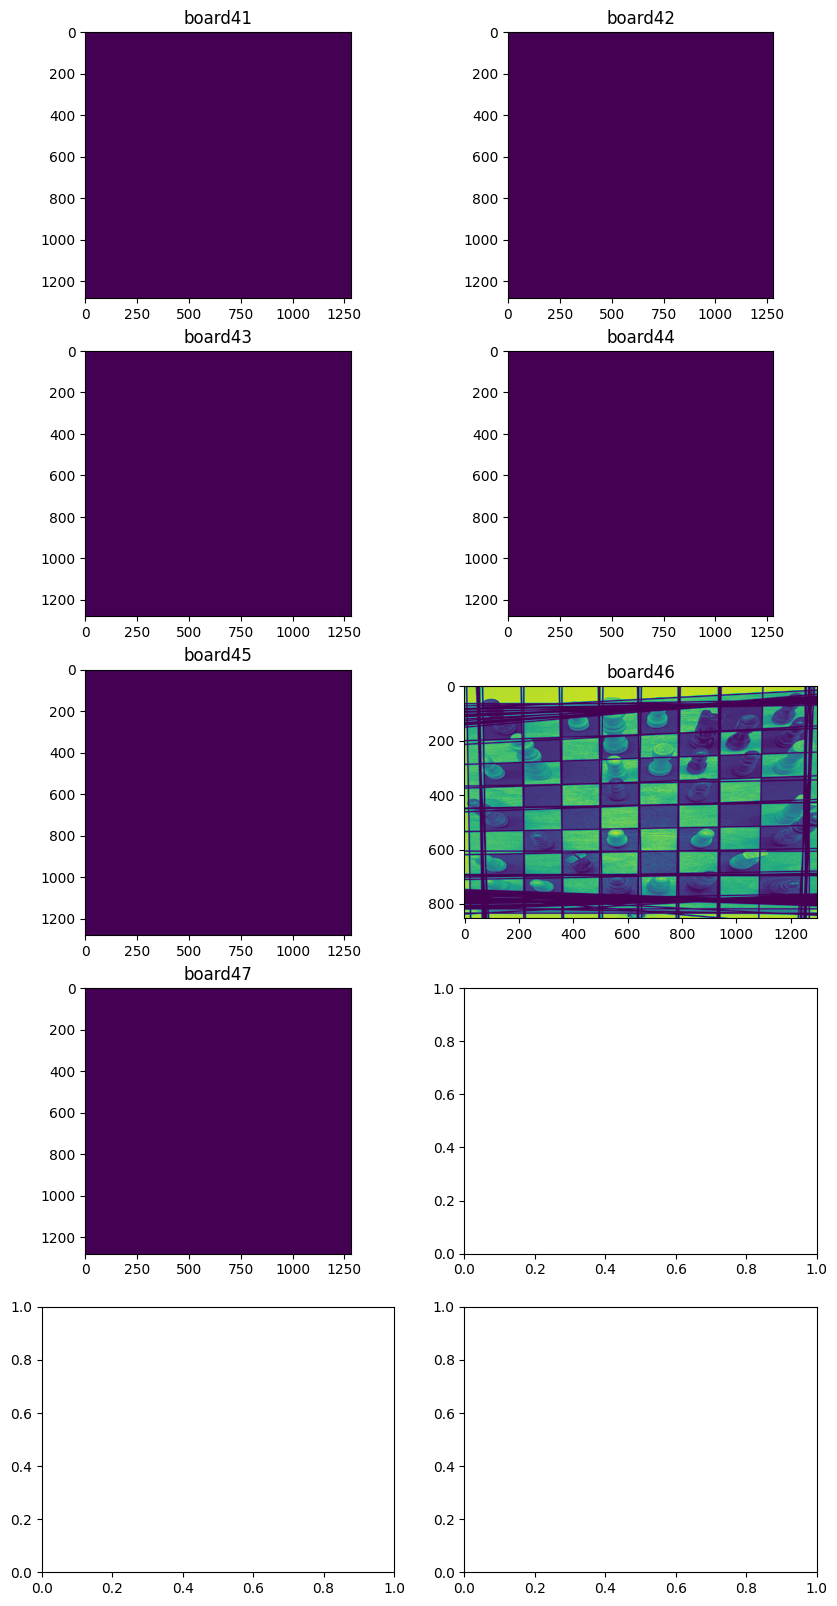

In [17]:
hough_lines = []
img_lined = []

for edge, img in zip(trans_edges, trans_img):
    v = int(np.median(img))
    lines = cv.HoughLines(edge, 1, np.pi/180, v *2)
    hough_lines.append(lines)
    img_line = img.copy()
    if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1500*(-b)), int(y0 + 1500*(a)))
            pt2 = (int(x0 - 1500*(-b)), int(y0 - 1500*(a)))
            cv.line(img_line, pt1, pt2, (0,0,152), 3, cv.LINE_AA)
    img_lined.append(img_line)
display_multiple_img(img_lined)

### Filtering the lines

In [18]:
horizontal_lines = []
vertical_lines = []
total_lines = []

for lines in hough_lines:
    
    if lines is not None:

        df = pd.DataFrame(lines[:,0,:]).rename(columns={0: "Rho", 1: "Theta"})
        df["diff"] = df["Rho"].diff() + 10*np.abs(df["Theta"].diff())
        new_lines = df
        new_lines["a"] = new_lines["Theta"].apply(math.cos)
        new_lines["b"] = new_lines["Theta"].apply(math.sin)
        new_lines["slope"] = -new_lines["a"]/new_lines["b"]
        new_lines["intercept"] = new_lines["Rho"]/new_lines["b"]

        mask_vert = (np.abs(new_lines["a"]) > 0.97) & (np.abs(new_lines["b"]) < 0.2 )
        mask = new_lines.isin([np.inf]).any(axis=1)
        vertical_2 = new_lines[mask + mask_vert]
        horizontal = new_lines[~(mask + mask_vert)]

        horizontal = horizontal.sort_values(by="intercept")
        horizontal["diff"] = horizontal["intercept"].diff()
        horizontal_f = horizontal[(horizontal["diff"]>50) | horizontal["diff"].isna()]

        vertical_2["x_intercept"] = vertical_2["Rho"].abs()
        vertical_2 = vertical_2.sort_values(by="x_intercept")
        vertical_2["diff"] = np.abs(vertical_2["x_intercept"]).diff()
        vertical_2_f = vertical_2[(vertical_2["diff"] > 60) | (vertical_2["diff"].isna())]

        horizontal_lines.append(horizontal_f)
        vertical_lines.append(vertical_2_f)
        total_lines.append(len(new_lines))
    
    else: 
        horizontal_lines.append(None)
        vertical_lines.append(None)
        total_lines.append(None)

/tmp/ipykernel_4836/1861147154.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vertical_2["x_intercept"] = vertical_2["Rho"].abs()


### Displaying the lines

In [19]:
r = 1

fig, axs = plt.subplots(5,2,figsize=(10,20))

for horizontal, vertical, total, img in zip(horizontal_lines, vertical_lines, total_lines, trans_img):
   
    plt.subplot(5,2,r)
    plt.title(f"board{r}")
    x = np.linspace(0, img.shape[1],total)
    x_h = horizontal["slope"].tolist()
    y_h = horizontal["intercept"].tolist()
    for i in range(len(x_h)):
        y = x_h[i] * x + y_h[i]
        plt.plot(x, y, '-r', label = f"line{i}")
        ax = plt.gca()
        ax.set_xlim([0, img.shape[1]])
        ax.set_ylim([img.shape[0], 0])

    vert = vertical["Rho"].tolist()
    x_v = vertical["slope"].tolist()
    y_v = vertical["intercept"].tolist()
    for i in range(len(x_v)):
        if x_v[i] == np.inf or x_v[i] == -np.inf:
            plt.axvline(x = vert[i], color = 'b')
        else: 
            y = x_v[i] * x + y_v[i]
            plt.plot(x, y, '-b', label = f"line{i}")
    plt.imshow(img)
    r += 1

TypeError: 'NoneType' object cannot be interpreted as an integer

### Intersections

In [ ]:
def intersection(line1, line2):
    if np.inf not in [line1[0], line1[1], line2[0], line2[1]] or -np.inf not in [line1[0], line1[1], line2[0], line2[1]]:
        x0 = (line2[1] - line1[1]) / (line1[0] - line2[0])
        y0 = line1[0] * x0 + line1[1]
    else:
        if np.inf in line1 or -np.inf in line1:
            linev = line1
            linenv = line2
        else:
            linev = line2
            linenv = line1
        x0 = linev[2]
        y0 = linenv[0] * x0 + linenv[1]
        
    return x0, y0

In [ ]:
intersections = []
intersection_df = []

for horizontal, vertical in zip(horizontal_lines, vertical_lines):
    intersections_p = []
    total_lines = pd.concat([horizontal, vertical])

    x_l = total_lines["slope"]
    y_l = total_lines["intercept"]
    r_l = total_lines["Rho"]

    for x1,y1,r1 in zip(x_l, y_l, r_l):
        for x2,y2,r2 in zip(x_l, y_l, r_l):
            line1 = (x1, y1, r1)
            line2 = (x2, y2, r2)
            if line1 != line2:
                if line1[0] - line2[0] != 0:
                    x0, y0 = intersection(line1, line2)
                    intersections_p.append((round(x0,0), round(y0,0)))

    intersections_pd = pd.DataFrame(intersections_p)
    intersections_pd = intersections_pd[intersections_pd>0][intersections_pd<1400].dropna().drop_duplicates().reset_index()
    x_in = intersections_pd[0].to_list()
    y_in = intersections_pd[1].to_list()
    
    intersection_df.append(intersections_pd)
    intersections.append((x_in, y_in))

### Displaying the intersections

In [ ]:
x = np.linspace(0,1500)
i = 0
r = 1
img_inter = []
fig, axs = plt.subplots(5,2,figsize=(10,20))

for inter, img, horizontal, vertical in zip(intersections,trans_img, horizontal_lines, vertical_lines):
    plt.subplot(5,2,r)
    plt.title(f"board{r}")
    img_2 = Image.fromarray(img)
    for i in range(len(inter[0])):
        text = f"{i}"
        x1 = inter[0][i]
        y1 = inter[1][i]
        plt.plot(x1,y1, marker="o", markersize=7, markerfacecolor="black")
        ax = plt.gca()
        ax.set_xlim([0, img.shape[1]])
        ax.set_ylim([img.shape[1], 0])
        draw = ImageDraw.Draw(img_2)
        font_type = ImageFont.truetype("arial.ttf", 40)
        draw.text((x1+20,y1+20),text, font=font_type, fill=255)
    img_inter.append(img_2)
    
    x_h = horizontal["slope"].tolist()
    y_h = horizontal["intercept"].tolist()
    vert = vertical["Rho"].tolist()
    x_v = vertical["slope"].tolist()
    y_v = vertical["intercept"].tolist()
    
    for i in range(len(x_h)):
        y = x_h[i] * x + y_h[i]
        plt.plot(x, y, '-r', label = f"line{i}")
        ax = plt.gca()
        ax.set_xlim([0, out.shape[1]])
        ax.set_ylim([out.shape[0], 0])

    for i in range(len(x_v)):
        if x_v[i] == np.inf or x_v[i] == -np.inf:
            plt.axvline(x = vert[i], color = 'b')
        else: 
            y = x_v[i] * x + y_v[i]
            plt.plot(x, y, '-b', label = f"line{i}")
    plt.imshow(img_2, cmap="gray")
    r += 1

### Coordinate system

In [ ]:
coordinates = []
for inter in intersection_df:
    if len(inter) > 68:
        inter = inter.drop(columns="index")
        A0 = inter.loc[0].to_list()
        coordinate = {}
        letters = ["A", "B", "C", "D", "E", "F", "G", "H"]
        i = 0
        for col in letters:
            for line in range(8):
                val = inter.loc[10+i + 9*line].to_list()
                text = f"{col}{line}"
                coordinate[text] = val
            i += 1
    coordinates.append(coordinate)

In [ ]:
img_coor = []  
for img, coordinate in zip(trans_img, coordinates):
    img_3 = Image.fromarray(img)
    for key, value in coordinate.items():
        text = key
        pos = (value[0]-100, value[1]-100)
        draw = ImageDraw.Draw(img_3)
        font_type = ImageFont.truetype("arial.ttf", 50)
        draw.text(pos,text, font=font_type, fill=255)
    img_coor.append(img_3)
display_multiple_img(img_coor)

In [ ]:
save_path = "/home/thierry/code/zuzannaszu/chess_hackers/Test_images"
for i, img in enumerate (img_coor):
    save_name = save_path + "/" + "board" + str(img_num[i]) + ".jpeg"
    img_3.save(save_name, format="jpeg")

In [ ]:
fig, axs = plt.subplots(2,5,figsize=(30,10))
for i, img in enumerate (img_coor, 1):
    plt.subplot(2,5,i)
    plt.imshow(img, cmap="gray")
    plt.title(f"board{i}")